## Прогнозирование группы пользователей для осуществления таргетированной рекламы банковского продукта

### Описание проекта
Задача банка предложить потребительский кредит и при этом максимизировать [показатель конверсии](https://www.unisender.com/ru/support/about/glossary/chto-takoe-cr-conversion-rate/), который равен отношению количества пользователей, принявших кредит, к общему количеству пользователей, которым поступили предложения *(precision)*. Решение этой задачи актуально для банка, потому что это позволит сократить расходы на персональный маркетинг, но при этом достичь максимальной выгоды. Данный проект оптимизирует выбор кандидатов для персонального предложения о предоставлении кредита. В процесс отбора кандидатов можно внерить алгоритм отсева потенциальных кандидатов, готовых взять кредит. 
### Постановка бизнес и математической задачи
Предположительно, нам известно сколько было затрачено времени и средств на проведение прошлогодней кампании. Для измерения бизнес цели мы планируем использовать сравнение затраченных и полученных средств текущей и прошлогодней кампании. Критерий успеха — доход, превышающий доход прошлогодней кампании (или превышение предсказанных показателей дохода, тк может быть тренд увеличения прибыли).

С математической точки зрения мы хотим, чтобы как можно больше людей из тех, кого мы выберем приняли наше предложение. Нам требуется построить бинарный классификатор, с вероятностными прогнозами. Для повышения показателя конверсии нам необходимо оптимизировать precision, но так же необходимо охватить больше потенциально согласных пользователей, поэтому мы будем оптимизировать __F1 score__ и следить за __precision__.

### Особенности предметной области
Для банковской сферы показатели качества часто бывают гораздо менее важными, чем простота самой модели и простота ее интерпретации. Это следует учесть при выборе финальной модели.

### Содержание 
+ [Описание колонок](#description_cell)
+ [EDA](#eda_cell)
+ [Train/Test split](#split_metrics_cell)
+ [Baseline](#baseline_cell)
+ [Feature engineering](#feature_cell)
+ [Model building](#model_cell)
+ [Conclusion](#conclusion_cell)

In [1]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score

from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.base import BaseEstimator

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

from graphviz import Source
from sklearn import tree

RANDOM_STATE = 12

In [2]:
file_name = "BPL.csv"
df = pd.read_csv(file_name)
df.head(5)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


<a id='description_cell'></a>

## Описание колонок
* **ID** : ID пользователя

* **Age** : Число полных лет пользователя

* **Experience** : Стаж работы

* **Income** : Годовой доход в тысячах долларов

* **ZIP Code** : Почтовый индекс

* **Family** : Размер семьи

* **CCAvg** : Средняя трата по кредитной карте за месяц

* **Education** : Степень образования.
   1. Среднее  
   2. Высшее  
   3. Доктор наук  
   

* **Mortgage** : Стоимость ипотеки при наличии. (в тысячах долларов)

* **Personal Loan** : Принял ли клиент предожение в прошлогодней кампании

* **Securities Account** : Есть ли у клиента счет в банке с ценными бумагами(брокерский счет)

* **CD Account** : Есть ли у клиента банковский вклад

* **Online** : Пользуется ли клиент услугами интернет - банкинга?

* **Credit card** : Использует ли клиент кредитную карту, выпущенную банком

<a id='eda_cell'></a>

# EDA

In [3]:
# there are no missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


Видим, что все колонки имеют тип данных int64. Так как в датасете присутствует 5000 семплов, пропущенных значений не наблюдается.
Некоторые колонки можно интерпретировать одновременно и как категориальные, и как номенативные.

In [4]:
# numeric and categorical features
num_cols = ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage', 'Family', 'Education', 'ZIP Code']
intersection_cols = ['Education', 'Family']
cat_cols = list((set(df.columns) - set(num_cols)).union(set(intersection_cols)))

print('Numeric Columns:', num_cols)
print('Categorical Columns:', cat_cols)
print('Intersection Columns:', intersection_cols)

Numeric Columns: ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage', 'Family', 'Education', 'ZIP Code']
Categorical Columns: ['Online', 'ID', 'Personal Loan', 'CreditCard', 'Family', 'CD Account', 'Education', 'Securities Account']
Intersection Columns: ['Education', 'Family']


In [5]:
df.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [6]:
df.describe().loc['min']

ID                       1.0
Age                     23.0
Experience              -3.0
Income                   8.0
ZIP Code              9307.0
Family                   1.0
CCAvg                    0.0
Education                1.0
Mortgage                 0.0
Personal Loan            0.0
Securities Account       0.0
CD Account               0.0
Online                   0.0
CreditCard               0.0
Name: min, dtype: float64

In [7]:
print(df[df['Experience'] < 0].shape)
df[df['Experience'] < 0].sample(10)

(52, 14)


,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
2466,2467,24,-2,80,94105,2,1.60,3,0,0,0,0,1,0
2618,2619,23,-3,55,92704,3,2.40,2,145,0,0,0,1,0
4411,4412,23,-2,75,90291,2,1.80,2,0,0,0,0,1,1
3425,3426,23,-1,12,91605,4,1.00,1,90,0,0,0,1,0
4957,4958,29,-1,50,95842,2,1.75,3,0,0,0,0,0,1
2980,2981,25,-1,53,94305,3,2.40,2,0,0,0,0,0,0
2545,2546,25,-1,39,94720,3,2.40,2,0,0,0,0,1,0
2962,2963,23,-2,81,91711,2,1.80,2,0,0,0,0,0,0
686,687,24,-1,38,92612,4,0.60,2,0,0,0,0,1,0
3157,3158,23,-1,13,94720,4,1.00,1,84,0,0,0,1,0


В колонке Experience мы можем наблюдать отрицательные значения. Это могут быть различные категории/причины отсутствия опыта работы у людей. Данный момент следует уточнить у заказчика, либо внедрить какие-то изменения в колонку Experience.

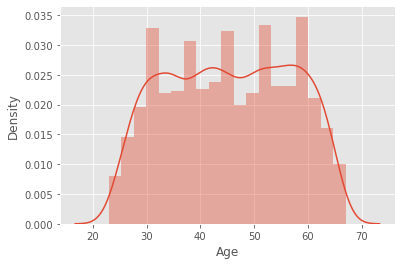

In [8]:
sns.distplot(df['Age'])
plt.show()

In [9]:
df['Personal Loan'].value_counts()

0    4520
1     480
Name: Personal Loan, dtype: int64

Мы имеем дело с бинарной классификацией по сильно несбалансированной выборке(9:1)  
Рассмотрим корреляцию признаков

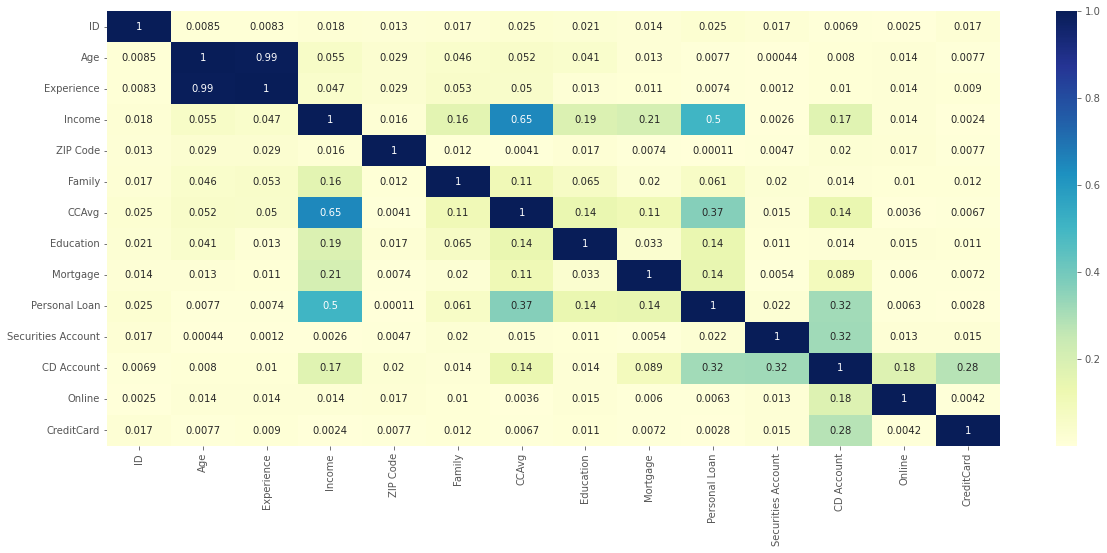

In [10]:
plt.figure(figsize=(20,8))
sns.heatmap(abs(df.corr()), annot=True, fmt='.2g',cmap='YlGnBu')
plt.show()

Видно, что признаки **Experience** и **Age** коррелируют, следовательно, мы можем оставить в данных какой-нибудь один из них

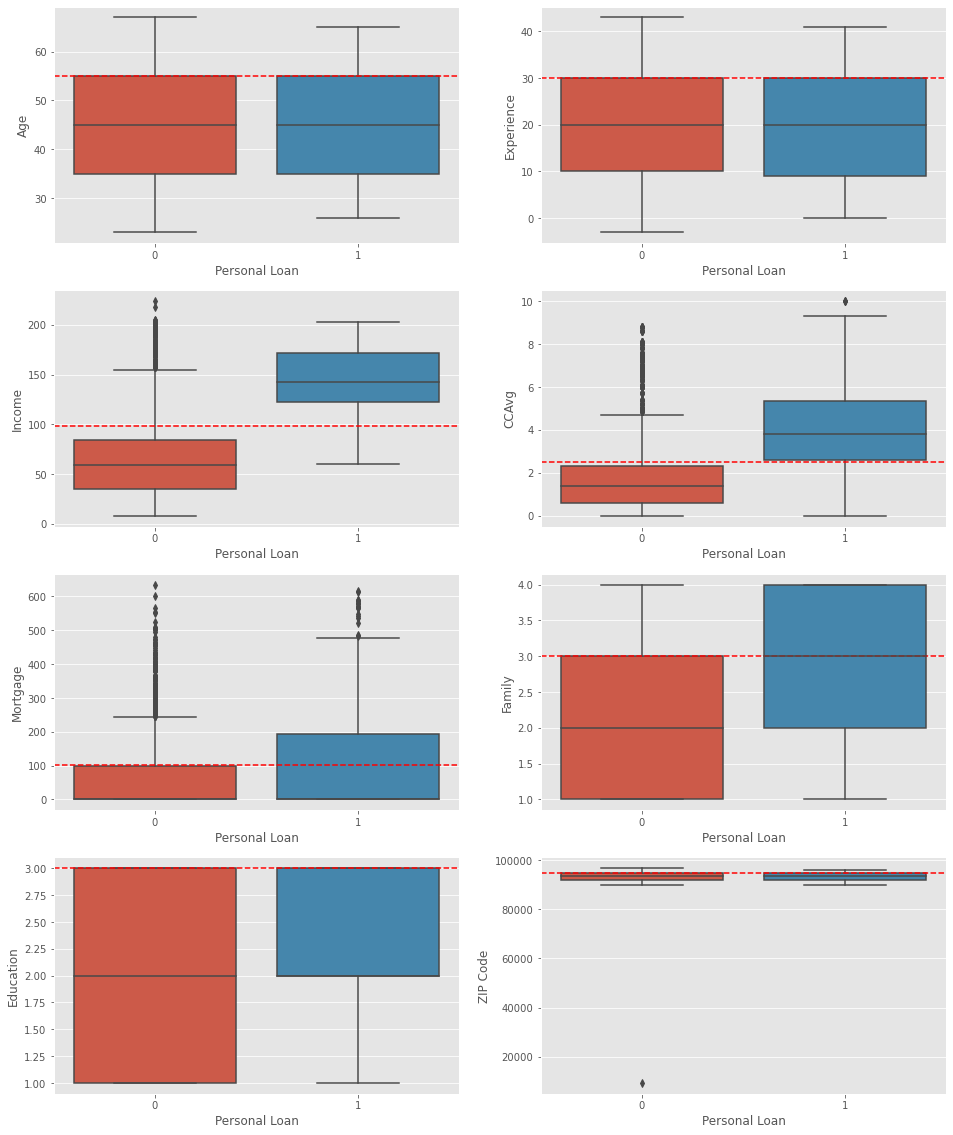

In [11]:
# feature importance
fig, ax = plt.subplots(4, 2, figsize=(16, 20))

for current_column, axis in zip(num_cols, ax.flatten()):
    sns.boxplot(x='Personal Loan', y=current_column, data=df, ax=axis)
    axis.axhline(df.describe().loc['75%', current_column], ls='--', c='red')

Из графиков видно, что:
* **Age** и **Experience** помимо того, что сильно коррелируют друг с другом, плохо предсказывают целевую переменную
* **Mortgage** имеет много нулевых значений, следовательно имеет смысл сделать отдельно категориальную колонку, отвечающую за наличие у человека иппотеки
* Аналогично предыдущему пункту, имеет смысл добавить к **Family** категориальную составляющую, так как наличие членов семьи сильно влияет на целевую переменную
* **Income** и **CCAvg** являются самымим информативными для предсказания таргета

<a id='split_metrics_cell'></a>

# Train/test split + metrics

In [12]:
target_col = ['Personal Loan']

X, y = df.drop(target_col, axis=1), df[target_col]
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                            stratify = y, random_state=RANDOM_STATE)
metrics = {'accuracy': accuracy_score,
           'precision': precision_score,
           'recall': recall_score,
           'roc_auc': roc_auc_score, 
           'f1': f1_score}

<a id='baseline_cell'></a>

# Baseline

Из графиков видно, что параметр дохода явлеется самым информативнм для нас. Сейчас, для выбора пользователей, которые получат персональные предложения, банк искользовал разделение по уровню дохода. Данная модель является имеет слабую конверсию, однако является очень простой в интерпретации для конечного пользователя, что очень важно в банковской сфере. 
Будем отталкиваться от разбиения по параметру Income.

In [13]:
means = df.groupby('Personal Loan')['Income'].mean()
means

Personal Loan
0     66.237389
1    144.745833
Name: Income, dtype: float64

In [14]:
threshold = means.mean()
def baseline_predict(df):
    return df['Income']>threshold
print('Baseline results')
bpred=baseline_predict(X_test_raw)
for score_name, score in metrics.items():
        print(score_name+': '+str(score(y_test,bpred)))

Baseline results
accuracy: 0.854
precision: 0.39035087719298245
recall: 0.9270833333333334
roc_auc: 0.8866611356932155
f1: 0.5493827160493827


<a id='feature_cell'></a>

# Feature engineering

In [15]:
train_columns = []

class FeatureSelector(TransformerMixin, BaseEstimator):
    '''
    Custom Transforemr.
    Drops columns: ID, ZIP Code,'Age, Experience.
    '''

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # transform X via code or additional methods
        
        # опустим коды сотрудников (ID, ZIP Code),
        # а также признаки Age и Experience, в связи с их неинформативностью
        X = X.drop(["ID", "ZIP Code", 'Age', 'Experience'], axis=1) 
        
        global train_columns
        train_columns = X.columns

        return X
    
    
class FeatureGemerator(TransformerMixin, BaseEstimator):
    '''
    Custom Transforemr.
    Creates several categorical columns
    '''
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # transform X via code or additional methods
        
        # is sth features
        X['IsMortgaged'] = X['Mortgage'] > 0
        X['IsFamily'] = X['Family'] > 1
        X['IsEducated'] = X['Education'] > 1

        # Is > than 75 qq
        X['IsMortgaged75'] = (X['Mortgage'] > X.describe().loc['75%', 'Mortgage']) & X['IsMortgaged']
        X['IsIncome75'] = X['Income'] > X.describe().loc['75%', 'Income']
        X['IsCCAvg75'] = X['CCAvg'] > X.describe().loc['75%', 'CCAvg']
        
        return X
    
def add_layer_to_pipeline(pipeline, layer,
                             pipeline_name='pipe', layer_name='model'):
    new_pipeline = Pipeline([
        (pipeline_name, pipeline),
        (layer_name, layer)
    ])
    
    return new_pipeline

In [16]:
# creating a pipeline to preprocess data in future
data_engeneering_pipeline = Pipeline([
    ('feature_generator', FeatureGemerator()),
    ('feature_selector', FeatureSelector())
#    ('scaler', StandardScaler())
])

# savling pipeline
joblib.dump(data_engeneering_pipeline, 'data_engeneering_pipeline.pkl')

['data_engeneering_pipeline.pkl']

<a id='model_cell'></a>

## Построение модели

В связи с особенностями предметной области, выбор финальной модели будет стоять из просто-интерпретируемых моделей, таких как Деревья решений и Линейные модели. Также необходимо оценить насколько данные модели будут уступать наиболее популярным аналогам для решения задач с табличными данными. 

In [17]:
# results of preprocessing
X_train = data_engeneering_pipeline.fit_transform(X_train_raw)
X_test = data_engeneering_pipeline.fit_transform(X_test_raw)

In [18]:
X_train


,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,IsMortgaged,IsFamily,IsEducated,IsMortgaged75,IsIncome75,IsCCAvg75
4850,119,1,2.9,1,0,1,0,1,0,False,False,False,False,True,True
3041,92,2,0.6,1,0,0,0,1,0,False,True,False,False,False,False
2647,155,1,2.9,1,0,0,0,1,0,False,False,False,False,True,True
549,35,3,1.3,2,0,0,0,0,1,False,True,True,False,False,False
2809,185,3,2.2,2,0,1,1,1,1,False,True,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,161,3,6.5,2,485,1,1,0,0,True,True,True,True,True,True
1512,44,3,1.7,1,0,0,0,0,0,False,True,False,False,False,False
4471,79,3,0.8,1,302,0,0,0,0,True,True,False,True,False,False
4260,52,1,1.4,1,0,0,0,1,0,False,False,False,False,False,False


In [22]:
# initializing models, their params and metrics



cat_features=['IsMortgaged','IsFamily','IsEducated','IsMortgaged75','IsIncome75','IsCCAvg75',
             'Education','Mortgage', 'Securities Account', 'CD Account', 'Online', 'CreditCard']
models = { 'CatBoostClassifier' : CatBoostClassifier(),
            'RandomForestClassifier': RandomForestClassifier(),
          'LogisticRegression': LogisticRegression(),
          'DecisionTreeClassifier': DecisionTreeClassifier(),
          'KNeighborsClassifier': KNeighborsClassifier(),
          'GradientBoostingClassifier': GradientBoostingClassifier(),
         
         }

params = {'LogisticRegression': {'C': np.linspace(0.01,2,15),
                                 'penalty': ['l1','l2', 'elasticnet', 'none'], 
                                 'random_state': [RANDOM_STATE]},
          'RandomForestClassifier': {'max_features': [1,3,10],
                                      'min_samples_split': [2,3,10],
                                      'min_samples_leaf': [1,3,10],
                                      'bootstrap': [False, True],
                                      'n_estimators': [50, 100, 200, 300],
                                      'n_jobs': [-1], 
                                      'random_state': [RANDOM_STATE]},
          'DecisionTreeClassifier': {'splitter': ['best', 'random'],
                                     'max_depth': ['none'] + [i for i in range(3, 9)], 
                                     'random_state': [RANDOM_STATE]},
          'KNeighborsClassifier':  {'n_neighbors': np.arange(1,50),
                                    'weights': ['uniform', 'distance']},
          'GradientBoostingClassifier': {'learning_rate': [0.001,0.01,0.1,0.05],
                                         'n_estimators': [100,500,1000],
                                         'max_depth': [3,5,10],
                                         'min_samples_split': [2,5,10], 
                                         'random_state': [RANDOM_STATE]},
          'CatBoostClassifier' : {'iterations':[500],
                                'depth' : [8],
                                'learning_rate' :[0.03],
                                 'l2_leaf_reg' : [3],
                                'eval_metric':["F1"],
                                'loss_function' : ["Logloss"],
                                #'task_type' : ["GPU"],
                                'leaf_estimation_iterations' : [10],
                                'max_ctr_complexity' : [5,8],
                                'random_seed': [RANDOM_STATE],
                                'cat_features'  : [ cat_features]}
}


In [23]:
def train_grdsearch_and_evaluate(X_train, y_train, X_test, y_test, 
                                 models=models, params=params, metrics=metrics, 
                                 n_jobs=-1, verbose=1, scoring='f1', n_splits=5):
    '''
    Returns a matrix (pd.DataFrame) of scores, dict of best_models \
    and dict of their best validation_scores(roc_auc)  
    '''
    
    best_scores={}
    best_estimators={}
    
    df_models = []
    df_training_scores = []
    df_scores = {metric_name:[] for metric_name, _ in metrics.items()}
    
    df = pd.DataFrame(columns=['model']) 
    for model_name, model in models.items():
        search = GridSearchCV(model, param_grid=params[model_name], 
                              cv=StratifiedKFold(n_splits=n_splits), scoring=scoring,
                              n_jobs=n_jobs, verbose=verbose).fit(X_train, y_train)
        
        best_scores[model_name] = search.best_score_
        best_estimators[model_name] = search.best_estimator_       
        print(f'Model: {model_name},\nBest score: \
        {best_scores[model_name]}\nBest params: {best_estimators[model_name]}')            
        
        df_models.append(model_name)
        for score_name, score in metrics.items():
            # f1 and accuracy don't work with probas
            # Also RFClassifier don't have predict_proba
            try:
                preds = search.predict_proba(X_test)
                df_scores[score_name].append(score(y_test, preds))
            except Exception as e:
                preds = search.predict(X_test)
                df_scores[score_name].append(score(y_test, preds))
    df['model'] = df_models   
    for score_name, _ in df_scores.items():
        df[score_name] = df_scores[score_name]    
    return df, best_estimators, best_scores

In [24]:
%%time
scoring_df, best_params, best_scores = train_grdsearch_and_evaluate(X_train, y_train, X_test, y_test, scoring='f1')

Fitting 5 folds for each of 2 candidates, totalling 10 fits
0:	learn: 0.6137725	total: 180ms	remaining: 2m 59s
1:	learn: 0.9205922	total: 235ms	remaining: 1m 57s
2:	learn: 0.9177127	total: 264ms	remaining: 1m 27s
3:	learn: 0.9185393	total: 287ms	remaining: 1m 11s
4:	learn: 0.9254144	total: 309ms	remaining: 1m 1s
5:	learn: 0.9108911	total: 323ms	remaining: 53.6s
6:	learn: 0.9108911	total: 346ms	remaining: 49s
7:	learn: 0.9078014	total: 357ms	remaining: 44.2s
8:	learn: 0.8936782	total: 366ms	remaining: 40.3s
9:	learn: 0.8965517	total: 384ms	remaining: 38s
10:	learn: 0.8984263	total: 400ms	remaining: 35.9s
11:	learn: 0.8984263	total: 410ms	remaining: 33.8s
12:	learn: 0.9002849	total: 432ms	remaining: 32.8s
13:	learn: 0.9049645	total: 455ms	remaining: 32s
14:	learn: 0.9049645	total: 469ms	remaining: 30.8s
15:	learn: 0.9080622	total: 487ms	remaining: 30s
16:	learn: 0.9096045	total: 507ms	remaining: 29.3s
17:	learn: 0.9111425	total: 529ms	remaining: 28.9s
18:	learn: 0.9172511	total: 553ms	re

167:	learn: 0.9800797	total: 3.76s	remaining: 18.6s
168:	learn: 0.9814324	total: 3.78s	remaining: 18.6s
169:	learn: 0.9854690	total: 3.8s	remaining: 18.6s
170:	learn: 0.9854690	total: 3.83s	remaining: 18.5s
171:	learn: 0.9854690	total: 3.86s	remaining: 18.6s
172:	learn: 0.9854690	total: 3.9s	remaining: 18.6s
173:	learn: 0.9854690	total: 3.91s	remaining: 18.5s
174:	learn: 0.9854690	total: 3.94s	remaining: 18.6s
175:	learn: 0.9854690	total: 3.96s	remaining: 18.5s
176:	learn: 0.9854690	total: 3.98s	remaining: 18.5s
177:	learn: 0.9854690	total: 4.01s	remaining: 18.5s
178:	learn: 0.9854690	total: 4.03s	remaining: 18.5s
179:	learn: 0.9854690	total: 4.06s	remaining: 18.5s
180:	learn: 0.9854690	total: 4.09s	remaining: 18.5s
181:	learn: 0.9854690	total: 4.11s	remaining: 18.5s
182:	learn: 0.9854690	total: 4.12s	remaining: 18.4s
183:	learn: 0.9854690	total: 4.13s	remaining: 18.3s
184:	learn: 0.9854690	total: 4.16s	remaining: 18.3s
185:	learn: 0.9854690	total: 4.18s	remaining: 18.3s
186:	learn: 0.

333:	learn: 0.9973890	total: 7.38s	remaining: 14.7s
334:	learn: 0.9973890	total: 7.4s	remaining: 14.7s
335:	learn: 0.9973890	total: 7.43s	remaining: 14.7s
336:	learn: 0.9973890	total: 7.45s	remaining: 14.7s
337:	learn: 0.9973890	total: 7.47s	remaining: 14.6s
338:	learn: 0.9973890	total: 7.5s	remaining: 14.6s
339:	learn: 0.9973890	total: 7.52s	remaining: 14.6s
340:	learn: 0.9973890	total: 7.54s	remaining: 14.6s
341:	learn: 0.9973890	total: 7.56s	remaining: 14.6s
342:	learn: 0.9973890	total: 7.59s	remaining: 14.5s
343:	learn: 0.9973890	total: 7.61s	remaining: 14.5s
344:	learn: 0.9973890	total: 7.63s	remaining: 14.5s
345:	learn: 0.9973890	total: 7.65s	remaining: 14.5s
346:	learn: 0.9973890	total: 7.67s	remaining: 14.4s
347:	learn: 0.9973890	total: 7.7s	remaining: 14.4s
348:	learn: 0.9973890	total: 7.72s	remaining: 14.4s
349:	learn: 0.9973890	total: 7.74s	remaining: 14.4s
350:	learn: 0.9973890	total: 7.76s	remaining: 14.4s
351:	learn: 0.9973890	total: 7.79s	remaining: 14.3s
352:	learn: 0.9

499:	learn: 1.0000000	total: 11.2s	remaining: 11.2s
500:	learn: 1.0000000	total: 11.2s	remaining: 11.1s
501:	learn: 1.0000000	total: 11.2s	remaining: 11.1s
502:	learn: 1.0000000	total: 11.2s	remaining: 11.1s
503:	learn: 1.0000000	total: 11.2s	remaining: 11.1s
504:	learn: 1.0000000	total: 11.3s	remaining: 11s
505:	learn: 1.0000000	total: 11.3s	remaining: 11s
506:	learn: 1.0000000	total: 11.3s	remaining: 11s
507:	learn: 1.0000000	total: 11.3s	remaining: 11s
508:	learn: 1.0000000	total: 11.3s	remaining: 10.9s
509:	learn: 1.0000000	total: 11.4s	remaining: 10.9s
510:	learn: 1.0000000	total: 11.4s	remaining: 10.9s
511:	learn: 1.0000000	total: 11.4s	remaining: 10.9s
512:	learn: 1.0000000	total: 11.4s	remaining: 10.9s
513:	learn: 1.0000000	total: 11.5s	remaining: 10.8s
514:	learn: 1.0000000	total: 11.5s	remaining: 10.8s
515:	learn: 1.0000000	total: 11.5s	remaining: 10.8s
516:	learn: 1.0000000	total: 11.5s	remaining: 10.8s
517:	learn: 1.0000000	total: 11.5s	remaining: 10.7s
518:	learn: 1.000000

658:	learn: 1.0000000	total: 14.8s	remaining: 7.67s
659:	learn: 1.0000000	total: 14.9s	remaining: 7.65s
660:	learn: 1.0000000	total: 14.9s	remaining: 7.63s
661:	learn: 1.0000000	total: 14.9s	remaining: 7.61s
662:	learn: 1.0000000	total: 14.9s	remaining: 7.58s
663:	learn: 1.0000000	total: 14.9s	remaining: 7.56s
664:	learn: 1.0000000	total: 15s	remaining: 7.54s
665:	learn: 1.0000000	total: 15s	remaining: 7.52s
666:	learn: 1.0000000	total: 15s	remaining: 7.5s
667:	learn: 1.0000000	total: 15s	remaining: 7.48s
668:	learn: 1.0000000	total: 15.1s	remaining: 7.45s
669:	learn: 1.0000000	total: 15.1s	remaining: 7.43s
670:	learn: 1.0000000	total: 15.1s	remaining: 7.41s
671:	learn: 1.0000000	total: 15.1s	remaining: 7.39s
672:	learn: 1.0000000	total: 15.2s	remaining: 7.37s
673:	learn: 1.0000000	total: 15.2s	remaining: 7.34s
674:	learn: 1.0000000	total: 15.2s	remaining: 7.32s
675:	learn: 1.0000000	total: 15.2s	remaining: 7.3s
676:	learn: 1.0000000	total: 15.3s	remaining: 7.28s
677:	learn: 1.0000000	

822:	learn: 1.0000000	total: 18.7s	remaining: 4.01s
823:	learn: 1.0000000	total: 18.7s	remaining: 3.99s
824:	learn: 1.0000000	total: 18.7s	remaining: 3.97s
825:	learn: 1.0000000	total: 18.7s	remaining: 3.94s
826:	learn: 1.0000000	total: 18.8s	remaining: 3.92s
827:	learn: 1.0000000	total: 18.8s	remaining: 3.9s
828:	learn: 1.0000000	total: 18.8s	remaining: 3.88s
829:	learn: 1.0000000	total: 18.8s	remaining: 3.85s
830:	learn: 1.0000000	total: 18.8s	remaining: 3.83s
831:	learn: 1.0000000	total: 18.9s	remaining: 3.81s
832:	learn: 1.0000000	total: 18.9s	remaining: 3.79s
833:	learn: 1.0000000	total: 18.9s	remaining: 3.77s
834:	learn: 1.0000000	total: 18.9s	remaining: 3.74s
835:	learn: 1.0000000	total: 19s	remaining: 3.72s
836:	learn: 1.0000000	total: 19s	remaining: 3.7s
837:	learn: 1.0000000	total: 19s	remaining: 3.67s
838:	learn: 1.0000000	total: 19s	remaining: 3.65s
839:	learn: 1.0000000	total: 19.1s	remaining: 3.63s
840:	learn: 1.0000000	total: 19.1s	remaining: 3.61s
841:	learn: 1.0000000	

982:	learn: 1.0000000	total: 22.5s	remaining: 389ms
983:	learn: 1.0000000	total: 22.5s	remaining: 366ms
984:	learn: 1.0000000	total: 22.6s	remaining: 343ms
985:	learn: 1.0000000	total: 22.6s	remaining: 321ms
986:	learn: 1.0000000	total: 22.6s	remaining: 298ms
987:	learn: 1.0000000	total: 22.6s	remaining: 275ms
988:	learn: 1.0000000	total: 22.7s	remaining: 252ms
989:	learn: 1.0000000	total: 22.7s	remaining: 229ms
990:	learn: 1.0000000	total: 22.7s	remaining: 206ms
991:	learn: 1.0000000	total: 22.7s	remaining: 183ms
992:	learn: 1.0000000	total: 22.8s	remaining: 160ms
993:	learn: 1.0000000	total: 22.8s	remaining: 137ms
994:	learn: 1.0000000	total: 22.8s	remaining: 115ms
995:	learn: 1.0000000	total: 22.8s	remaining: 91.7ms
996:	learn: 1.0000000	total: 22.8s	remaining: 68.7ms
997:	learn: 1.0000000	total: 22.9s	remaining: 45.8ms
998:	learn: 1.0000000	total: 22.9s	remaining: 22.9ms
999:	learn: 1.0000000	total: 22.9s	remaining: 0us
Model: CatBoostClassifier,
Best score:         0.9460677968339

In [25]:
scoring_df

,model,accuracy,precision,recall,roc_auc,f1
0,CatBoostClassifier,0.981,0.952941,0.843750,0.919663,0.895028
1,RandomForestClassifier,0.980,0.952381,0.833333,0.914454,0.888889
2,LogisticRegression,0.968,0.872093,0.781250,0.884541,0.824176
3,DecisionTreeClassifier,0.980,0.941860,0.843750,0.919110,0.890110
4,KNeighborsClassifier,0.940,0.687500,0.687500,0.827157,0.687500
5,GradientBoostingClassifier,0.979,0.941176,0.833333,0.913901,0.883978


In [26]:
# save scores to csv
scoring_df.to_csv('scoring_df.csv', index=None)

In [27]:
# validation results
scoring_df = pd.read_csv('scoring_df.csv')
scoring_df

,model,accuracy,precision,recall,roc_auc,f1
0,CatBoostClassifier,0.981,0.952941,0.843750,0.919663,0.895028
1,RandomForestClassifier,0.980,0.952381,0.833333,0.914454,0.888889
2,LogisticRegression,0.968,0.872093,0.781250,0.884541,0.824176
3,DecisionTreeClassifier,0.980,0.941860,0.843750,0.919110,0.890110
4,KNeighborsClassifier,0.940,0.687500,0.687500,0.827157,0.687500
5,GradientBoostingClassifier,0.979,0.941176,0.833333,0.913901,0.883978


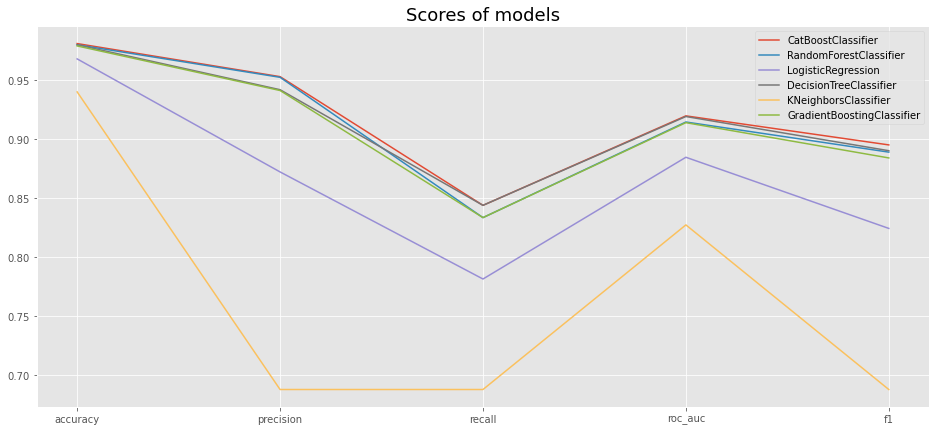

In [28]:
# validation vizualiazation
fig = plt.figure(figsize=(16, 7))
for i in range(len(scoring_df)):
    plt.plot(metrics.keys(), scoring_df.loc[i, metrics.keys()].values, label=scoring_df['model'][i])

plt.title('Scores of models', fontsize=18)
plt.legend();


Видим, что лучше всего себя показывают градиентный бустинг и случайный лес. Однако решающее дерево не сильно уступает двум данным моделям. Логистическая регрессия имеет наиболее низкий score.
Следовательно, наиболее оптимальным вариантом в данной задаче является использование решающего дерева в качестве финальной модели (за счет хорошей интерпритируемости).

Сохраним также модель с наибольшим показателем качества - случайный лес.

In [29]:
# final model with simple interpritetion
dtc = best_params['DecisionTreeClassifier']

#saving model
joblib.dump(dtc, 'models\DTree_model.pkl')

# final score

prob_preds = dtc.predict_proba(X_test)[:, 1]
preds = dtc.predict(X_test)
for score_name, score in metrics.items():
    try:
        print(score_name+': '+str(score(y_test,prob_preds)))
    except:
        print(score_name+': '+str(score(y_test,preds)))

accuracy: 0.98
precision: 0.9418604651162791
recall: 0.84375
roc_auc: 0.9842655328171092
f1: 0.8901098901098902


In [31]:
# final model with better results
rfc = best_params['RandomForestClassifier']
print('RandomForest')
#saving model
joblib.dump(rfc, 'models\\rfc_model.pkl')

# final score

prob_preds = rfc.predict_proba(X_test)[:, 1]
preds = rfc.predict(X_test)
for score_name, score in metrics.items():
    try:
        print(score_name+': '+str(score(y_test,prob_preds)))
    except:
        print(score_name+': '+str(score(y_test,preds)))
cb = best_params['CatBoostClassifier']

#saving model
joblib.dump(cb, 'models\\cb_model.pkl')

# final score
print('CatBoost')
prob_preds = cb.predict_proba(X_test)[:, 1]
preds = cb.predict(X_test)
for score_name, score in metrics.items():
    try:
        print(score_name+': '+str(score(y_test,prob_preds)))
    except:
        print(score_name+': '+str(score(y_test,preds)))

RandomForest
accuracy: 0.98
precision: 0.9523809523809523
recall: 0.8333333333333334
roc_auc: 0.9953908554572272
f1: 0.888888888888889
CatBoost
accuracy: 0.981
precision: 0.9529411764705882
recall: 0.84375
roc_auc: 0.9971308075221239
f1: 0.8950276243093922


In [37]:
cb.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Income,24.540048
1,Education,17.400316
2,Family,17.319301
3,CCAvg,16.400906
4,IsEducated,6.596283
5,Mortgage,3.353561
6,CD Account,3.083466
7,Online,2.791725
8,IsCCAvg75,2.542356
9,IsIncome75,2.343869


In [41]:
import shap
shap.initjs()

In [67]:
explainer = shap.TreeExplainer(cb)
shap_values = explainer.shap_values(X_test)

In [182]:
%matplotlib inline

In [195]:
from random import randint
rid = randint(0,X_test.shape[1]) 
label = cb.predict(X_test.iloc[rid,:])
proba = cb.predict_proba(X_test.iloc[rid,:])[label]


shap.force_plot(explainer.expected_value, shap_values[rid,:], X_test.iloc[rid,:],
                #out_names=f'with {proba:.3f} probability',
                #figsize=(19, 5),
                link="logit", 
                #text_rotation=15,
                #matplotlib=True,
               )

#### Таким образом мы получили хорошее качество классификации, высокую точность и достаточно большую полноту, что должно хорошо сказаться на экономической значимости, и наша кампании принесет больше прибыли, чем предыдущая

Как мы знаем, деревья решений можно легко интерпретировать с помощью визуализации бинарного дерева. Для этого нам понадобится вернуть данные в исходное состояние, и проделать все те же преобразования без этапа нормализации.

In [27]:
# preprocessing for ddtc

# pipeline with no normalization layer
pipe_raw = data_engeneering_pipeline[:2]

# getting new X_train & X_test (Non-normalized)
X_train_raw = pipe_raw.fit_transform(X_train_raw)
X_test_raw = pipe_raw.fit_transform(X_test_raw)

# stealing params from dtc
dtc_raw = DecisionTreeClassifier()
params = dtc.get_params()
dtc_raw.set_params(**params)

# fti & evaluate
dtc_raw.fit(X_train_raw, y_train)

prob_preds = dtc_raw.predict_proba(X_test)[:, 1]
preds = dtc_raw.predict(X_test)
for score_name, score in metrics.items():
    try:
        print(score_name+': '+str(score(y_test, prob_preds)))
    except:
        print(score_name+': '+str(score(y_test, preds)))

accuracy: 0.907
precision: 0.3333333333333333
recall: 0.010869565217391304
roc_auc: 0.5291850220264318
f1: 0.021052631578947368


Здесь происходит визуализация, но для ее корректной работы нужно поставить несколько библиотек и обновить переменные среды


In [28]:
#!pip install pydot
#!pip install graphviz

In [29]:

# visualization
#import graphviz

# DOT data
#dot_data = tree.export_graphviz(dtc_raw, out_file=None, 
#                                feature_names=train_columns,  
#                                class_names=['1', '0'],
#                               filled=True)

# Draw graph
#graph = graphviz.Source(dot_data, format="png") 
#graph.save('dtc_raw_tree.dot')


In [30]:
# export to png
#import pydot

#(graph,) = pydot.graph_from_dot_file('dtc_raw_tree.dot')
#graph.write_png('dtc_raw_tree.png')

Теперь в readme у нас есть картинка с интерпритацией

<a id='conclusion_cell'></a>

### Оценка экономической эфффективности 

In [31]:
dtc_preds = dtc.predict(X_test)
conversion_rate_old = float(y_test.sum() / y_test.shape[0])
conversion_rate_new = precision_score(y_test, dtc_preds)
missing_clients = 1 - recall_score(y_test, dtc_preds)
percent_of_new_candidates = dtc_preds.sum()/y_test.shape[0]
print(f'Старый показатель конверсии на тестовой выборке равен {conversion_rate_old * 100:.1f}%')
print(f'Новый показатель конверсии на тестовой выборке равен {conversion_rate_new * 100:.1f}%')
print(f'Потеряно {missing_clients * 100:.1f}% клиентов')
print(f'Количество новых кандидатов относительно старого способа составляет {percent_of_new_candidates* 100:.1f}%')

Старый показатель конверсии на тестовой выборке равен 9.2%
Новый показатель конверсии на тестовой выборке равен 89.7%
Потеряно 15.2% клиентов
Количество новых кандидатов относительно старого способа составляет 8.7%


Пусть затраты на маркетинг на одного клиента __N__, доход с одного клиента __M__, общее количеств клиентов __n__

Profit_old = (M * 0.092 - N) * n

Profit_new = (M * 0.897  - N) * 0.087 * n 

Delta = (-0.013 * M + 0.913 * N) * n                       

Допустим что, изначально было 5000 клиентов, на привлечение клиента мы тратим 50 рублей, а потенциальный профит составляет 1000 рублей, то при внедрении нашей системы мы получим 163250 рублей
Таким образом внедрение нашей модели позволит увеличить доход банка. 

In [32]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.24.2.
